In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.integrate as intgr
#Monkeypatch to fix heprops
from scipy.special import factorial
np.math = type('math', (), {})()
np.math.factorial = factorial

from heprops import helium as hel

In [3]:
plt.style.use('aps')
mpl.rcParams["figure.figsize"] = [3.4039, 2.10373]

Skip line
1.4


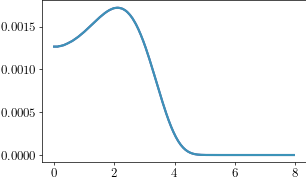

In [4]:
f2 = open('CsR8/radial-u-reduce.dat','r')
lines = f2.readlines()
u = np.array([])
N = np.array([])
delN = np.array([])

readindex = 0
rval = len(lines) - 2

for line in lines:
    if(readindex == 0):
        p = line.split()
        for j in range(1,len(p)):
            if (j % 3 == 0):
                u = np.append(u,float(p[j]))
        r = np.zeros((len(u),rval))
        rho = np.zeros((len(u),rval))
        delrho = np.zeros((len(u),rval))
    elif(readindex == 1):
        print("Skip line")
    else:
        #print(r)
        p = line.split()
        #print(p)
        #print(readindex)
        ind_arr = 3*np.arange(0,int(len(p)/3),1)
        for j in ind_arr:
            ind = int(j/3)
            r[ind,readindex - 2] = p[j]
            #print(p[j+1])
            rho[ind,readindex - 2] = p[j+1]
            delrho[ind,readindex - 2] = p[j+2] 
        #print(rho)
    readindex = readindex + 1
f2.close()
plt.plot(r[len(u)-10,:],rho[len(u)-10,:])
refR = len(u)-10
#print(rho[refR,:])
#minR = np.argmin(rho[refR,:])
#minRval = r[refR,minR]
minRval = 1.4
print(minRval)
rho1d = np.array([])
for i in range(len(u)):
    indx = r[i,:] < minRval
    rho1d = np.append(rho1d,2*np.pi*intgr.simpson(y = r[i,indx]*rho[i,indx], x = r[i,indx]))
sind = np.argsort(u)
uCs = u[sind]
rho1dCs = rho1d[sind]
#rhostar = max(rho1dCs)
#rho1dCs = rho1dCs/rhostar
PCs = hel.pressure(uCs,2)
PCsmax = max(PCs)
PCsmin = min(PCs)
PCsPlot = (PCs - PCsmin)/PCsmax
plt.plot(r[refR,:],rho[refR,:])
#print(rho1dCs)
#u = np.delete(u,[16,17,18,19,20,21])
#rho1d = np.delete(rho1d,[16,17,18,19,20,21])
#print(u[16])
#print(rho1d[16])

#plt.semilogy(u,hel.pressure(u,2))
#plt.yscale("log")
#plt.semilogx(hel.pressure(u,2),rho1d)
#plt.plot(r[i],rho[i],label='u = %.4f'%(u[i]))
#plt.legend()
#plt.savefig('rhovsPCsR6.pdf')
#plt.show(

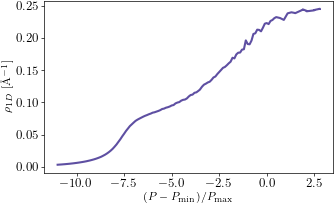

In [6]:
with plt.style.context('aps'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=(figsize[0],figsize[1]), constrained_layout=True)
    ax.plot(uCs,rho1dCs)
    #ax.semilogx(PCsPlot,rho1dCs,label=r'Cs',color='#5E4FA2')
    #ax.semilogx(PMgPlot,rho1dMg,label=r'Mg',color='#79C9A4')
    #ax.semilogx(PArPlot,rho1dAr,label=r'Ar',color='#D7414E')
    #ax.set_ylabel(r'$\frac{\rho_{1D}}{\rho_{1D}*}$')
    ax.set_xlabel(r'$(P - P_{\rm min})/P_{\rm max}$')
    #ax.set_xlim(1,1)
    ax.set_ylabel(r'$\rho_{1D}$ [Å$^{-1}]$')
    #ax.set_xlabel(r'$P$')
    #plt.legend(title="R = 8 Å",handlelength=1)
    plt.savefig('R8rho1d.pdf')